# From Keras to Pytorch
## And build "Coord Conv" with 4 lines of code

Keras
Yes yes, keras is friendlier for beginners.

#### Work well with google's tensorflow
Even the official ["get started" tutorial page of tensorflow](https://www.tensorflow.org/tutorials/) starts with keras api now (2018-07-12).

#### Simplicity
Keras doesn't complicate the DL when it's not necessary, like a dense layer should cost you a line of code, no more.

And choosing optimizer, loss function, extra metrics, all in one line of code.

#### Keras codes:
For using keras. See the previous notebooks

## Pytorch
Pytorch is another level of awesomeness, if tensorflow isn't from google and bear its reputation, pytorch should have taken the industry by now.

If you try reading paper, that has some interesting structure, method about DL, like different strategy between train/inference, several optimizer, a wierd shape of model and wierder strategy of updating them partially, or some time just a very unique loss function work with a very tailor made data generator.

I used to do those edgy models with keras. It's hard, it's just hard. Like modify a luxury hotel for a school or a hospital or a jail or all kinds of other buildings. The overhaul on engineering alone is nightmare 

![search trends on deep learning lib](docs/dl_lib_trends.png)

Among other convenient features, pytorch is trending, becoming the world's most used deep learning framework in AI labs.(Not yet for business)

Requirements

```
python 3.6

numpy == '1.14.3'
pandas == '0.23.0'
tensorflow == '1.8.0'
keras == '2.2.0'
tqdm == '4.23.4'
```
Other versions of above library will probably work

If you don't have any of these, try the following format in the command line:
```
~/anaconda3/bin/pip install keras==2.2.0
```
assuming your anaconda3 is at ```~/anaconda3/```

In [1]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

We are using the [fashion-mnist](https://github.com/zalandoresearch/fashion-mnist) dataset as the problem we are going to tackle today.

In [2]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize([.5,.5,.5],
                                                     [.5,.5,.5])])

Download the train data

In [3]:
ds = FashionMNIST("/data/fm",train = True, 
              transform=transform,
              download=True, # Set this to False second time you ran it
             )

Processing...
Done!


Use the validation data

In [143]:
ds_val = FashionMNIST("/data/fm",train = False, 
              transform=transform,
              download=False, # Set this to False second time you ran it
             )

### alternative downloading url:
In case it's too slow
Click this [tar.gz file address](http://45.76.223.58/fm.tar.gz) to download, you can uncomment the following and run 

In [ ]:
# %mkdir -p data
# %mkdir -p data/fm
# !!cd data; wget http://45.76.223.58/fm.tar.gz
# !!tar -xzvf fm.tar.gz; cd ..

In [308]:
from torch.utils.data import DataLoader

In [309]:
dl = DataLoader(ds,batch_size=64,shuffle=True,)
gen = iter(dl)

### Test dataset

In [310]:
x,y = next(gen)

In [12]:
x.size(),y.size()

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

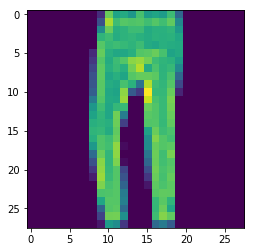

In [322]:
plt.imshow(x.numpy()[18].reshape(28,28))

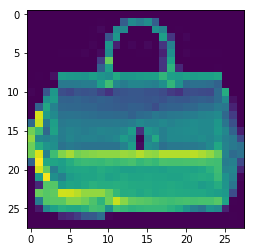

In [28]:
plt.imshow(x.numpy()[1].reshape(28,28))

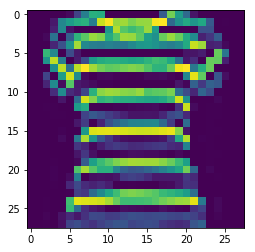

In [29]:
plt.imshow(x.numpy()[2].reshape(28,28))

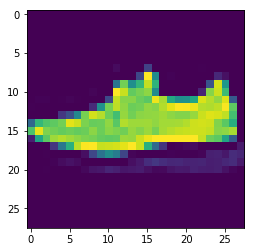

In [30]:
plt.imshow(x.numpy()[3].reshape(28,28))

### MLP (from previews session)

Starting what you are familiared with

In [88]:
from torch import nn
from torch.nn import functional as F

In [124]:
mlp_01 = nn.Sequential(*[
                        nn.Linear(28*28,512,bias=True),
                        nn.ReLU(),
                        nn.Linear(512,512,bias=True),
                        nn.ReLU(),
                        nn.Linear(512,10,bias=True),
                        nn.Softmax(dim=-1),
                        ])

In [125]:
from torch.optim import Adam
from torch import argmax
optimizer = Adam(mlp_01.parameters(),lr = 0.001)
loss_func = nn.CrossEntropyLoss()
def accuracy(y_pred, y_true):
    """
    :param y_pred: predition of y (will be argmaxed)
    :param y_true: true label of y (index)
    :return:
    """
    return (argmax(y_pred,dim=-1) == y_true).float().mean()

In [127]:
from tqdm import tnrange,tqdm_notebook,tqdm
import tqdm

In [129]:
dl = DataLoader(ds,batch_size=64,shuffle=True)
for j in tnrange(5):
    # make a generator out of dataloader
    gen = iter(dl)
    t =tqdm_notebook(range(len(dl)))
    loss_ = 0
    acc = 0
    for i in t:
        # get input data:x, supervising label:y
        x,y = next(gen)
        
        # flatten x, just like keras's x = Flatten()(x)
        bs = x.size()[0]
        x = x.resize_(bs,28*28)
        
        optimizer.zero_grad()
        
        # forward path
        y_ = mlp_01(x)
        # calculate loss
        loss = loss_func(y_,y)
        
        # back propagation (from loss to weights)
        loss.backward()
        optimizer.step()
        
        # Calculate metric: accuracy just to see how the model is in a percentage sense
        loss_ += loss.item()
        acc += accuracy(y_,y).item()
        
        if i%10==9:
            acc /= 10; loss_ /= 10
            t.set_postfix({"ðŸ˜Žaccuracy":acc,"ðŸ˜Žloss":loss_,})
            acc = 0; loss_ = 0
        

In [325]:
y_pred.argmax()

tensor(4)

### Steps with in a learning step

Assume the model is $\large y=f(x)$, This represent the entire model, whether it is LR, DNN, CNN, RNN. The parameters of the data is $\large \theta$. We want to feed $m$ rows of data, $\large {x}_{m}, {y}_{m}$, pair by pair into the model, to change/optimize $\large \theta$.

* Get the x, y data from generator, batch_size is number of rows of data/batch

* Clean the gradients

* Forward pass, predict a $\large \hat{y}$ using $\large \hat{y_{m}}=f(x_{m})$, it's telling the model to take a guess given $\large x_{m}$, $\large m$ means the current batch index

* Calculate loss, comparing the predict label, with supervising/guide lining/correct label, $\large L = CrossEntropy(\hat{y},y)$

* Using backward() function on loss to calculate gradients $\large \frac{\partial L}{\partial \theta}$, to measure in which way $\large \theta$'s change can effect $\large L$. 

* optimizer.step() to change $\large \theta$ in the direction for a tiny amount (learning rate $\large \alpha$)

Machine learning is to repeatedly do the above step. It's basicly what pytorch do during a batch

### Next Improvement

* Make use of valid dataset
* Wrapper for DL
* Simple Convolution

Uncomment the following and install the ray library

In [ ]:
# import os
# os.system("cd %s/lib/python3*/site-packages/;git clone https://github.com/raynardj/ray"%(os.environ["_"].split("/bin")[0]))

In [169]:
from ray import matchbox

In [193]:
trainer = matchbox.Trainer(dataset=ds,val_dataset=ds_val,batch_size=64)

In [194]:
def conv_block(in_,out_,ks=3):
    """
    return one convolutional block
    """
    return nn.Sequential(*[
        nn.Conv2d(in_channels=in_,out_channels=out_,kernel_size=ks,padding=ks//2,bias=True),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_,out_channels=out_,kernel_size=ks,padding=ks//2,bias=True),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_,out_channels=out_,kernel_size=ks,padding=ks//2,bias=True),
        nn.ReLU(),
        nn.MaxPool2d(2),
    ])

class Flatten(nn.Module):
    def forward(self, input):
        """
        a pytorch version of Flatten layer
        """
        return input.view(input.size(0), -1)

### A sequential CNN(Convolution Neural Network) model

In [195]:
cnn_01 = nn.Sequential(*[
                        # The shape is (batch size, number of channels, height, width)
                        conv_block(1,16), # shape in: (bs,1,28,28), out:(bs,16,14,14), grid size /2 because of max pooling
                        conv_block(16,32), # shape in: (bs,16,3,3), out:(bs,32,7,7),
                        conv_block(32,64), # shape in: (bs,32,7,7), out:(bs,64,3,3),
                        Flatten(), # shape in:(bs,64,3,3), out: (bs,64*3*3), dimension reduced
                        # The following are stardard MLP
                        nn.Linear(64*3*3,256,bias=False),
                        nn.BatchNorm1d(256),
                        nn.ReLU(),
                        nn.Dropout(.3),
                        nn.Linear(256,10),
                        nn.BatchNorm1d(10),
                        nn.Softmax(dim=-1),
                        ])
optimizer = Adam(cnn_01.parameters(),lr = 0.001)

In [196]:
def action(*args,**kwargs):
    """
    Define each training step
    """
    x,y = args[0]
    
    optimizer.zero_grad()
    y_ = cnn_01(x)
    
    loss = loss_func(y_,y)
    
    loss.backward()
    optimizer.step()
    
    return {
        "loss":loss.item(),
        "acc":accuracy(y_,y).item(),
           }
def val_action(*args,**kwargs):
    """
    Define each validation step
    """
    x,y = args[0]
    y_ = cnn_01(x)
    
    loss = loss_func(y_,y)
    return {
        "loss":loss.item(),
        "acc":accuracy(y_,y).item(),
           }

In [197]:
trainer.action = action
trainer.val_action = val_action
trainer.train(2)

### Excersice No 1

Build a model using conv block with Batch Normalization inside, here is the code to retuan a batchnormalzied conv block. you can use it for building model.

In [ ]:
def conv_block_bn(in_,out_,ks=3):
    """
    return one convolutional block
    """
    return nn.Sequential(*[
        nn.Conv2d(in_channels=in_,out_channels=out_,kernel_size=ks,padding=ks//2,bias=False), 
        # changed bias to False, Batchnorm has param size just like previous layer's bias, sort of perform alike also
        nn.BatchNorm2d(out_),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_,out_channels=out_,kernel_size=ks,padding=ks//2,bias=False),
        nn.BatchNorm2d(out_),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_,out_channels=out_,kernel_size=ks,padding=ks//2,bias=False),
        nn.BatchNorm2d(out_),
        nn.ReLU(),
        nn.MaxPool2d(2),
    ])

### Coord Conv Layer

Use objective oriented programming to for the coord conv, it's a technique to blend in the positional information(coordinations) in the convolution layer. Check the [coord conv paper](http://arxiv.org/abs/1807.03247).

Or check their [awesome blog post](https://eng.uber.com/coordconv/)

![coord_conv pic](docs/coord_conv.png)

In [198]:
import torch

In [238]:
class add_coord(nn.Module):
    def __init__(self):
        super(add_coord,self).__init__()
        
    def forward(self,x):
        bs,ch,h,w = x.size()
        h_coord = torch.range(start = 0,end = h-1).unsqueeze(0).unsqueeze(0).unsqueeze(-1).repeat([bs,1,1,w])/(h/2)-1
        w_coord = torch.range(start = 0,end = w-1).unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([bs,1,h,1])/(w/2)-1
        return torch.cat([x,h_coord,w_coord],dim=1)
    
class Coord2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride=1,padding=0,dilation=1,groups=1,bias=True):
        """
        Coord Convolution Module
        Coord2d(in_channels,out_channels,kernel_size,stride=1,padding=0,dilation=1,groups=1,bias=True)
        Use it just like using a normal pytorch nn.Module
        """
        super(Coord2d,self).__init__()
        self.add_coord = add_coord()
        self.conv = nn.Conv2d(in_channels=in_channels+2,
                              out_channels=out_channels,
                              kernel_size=kernel_size,stride=stride,padding=padding,dilation=dilation,groups=groups,bias=bias)
        
    def forward(self,x):
        x = self.add_coord(x)
        for i in range(5):
            x = self.ln1(x)
        x = self.conv(x)
        return x

I have wrapped up the above Coord2d code into my personal tool library: [ray](https://github.com/raynardj/ray)

From now on, you can from ray.matchbox_lego import Coord2d to use Coord2d module without writing the structure again

### Coord Conv Explained:

In [328]:
x = torch.rand(64,3,28,28)

In [329]:
bs,ch,h,w = x.size()
h_coord = torch.range(start = 0,end = h-1).unsqueeze(0).unsqueeze(0).unsqueeze(-1).repeat([bs,1,1,w])/(h/2)-1
w_coord = torch.range(start = 0,end = w-1).unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([bs,1,h,1])/(w/2)-1

In [241]:
h_coord.size()

torch.Size([64, 1, 28, 28])

In [345]:
torch.cat([x,h_coord,w_coord],dim=1).size()

torch.Size([64, 5, 28, 28])

In [242]:
def coord_block(in_,out_,ks=3):
    """
    return one convolutional block
    """
    return nn.Sequential(*[
#         nn.Conv2d(in_channels=in_,out_channels=out_,kernel_size=ks,padding=ks//2,bias=False),
        Coord2d(in_channels=in_,out_channels=out_,kernel_size=ks,padding=ks//2,bias=False), 
        nn.BatchNorm2d(out_),
        nn.ReLU(),
#         nn.Conv2d(in_channels=out_,out_channels=out_,kernel_size=ks,padding=ks//2,bias=False),
        Coord2d(in_channels=out_,out_channels=out_,kernel_size=ks,padding=ks//2,bias=False),
        nn.BatchNorm2d(out_),
        nn.ReLU(),
#         nn.Conv2d(in_channels=out_,out_channels=out_,kernel_size=ks,padding=ks//2,bias=False),
        Coord2d(in_channels=out_,out_channels=out_,kernel_size=ks,padding=ks//2,bias=False),
        nn.BatchNorm2d(out_),
        nn.ReLU(),
        nn.MaxPool2d(2),
    ])

The new model with coord conv

In [243]:
cnn_coord = nn.Sequential(*[
                        # The shape is (batch size, number of channels, height, width)
                        coord_block(1,16), # shape in: (bs,1,28,28), out:(bs,16,14,14), grid size /2 because of max pooling
                        coord_block(16,32), # shape in: (bs,16,3,3), out:(bs,32,7,7),
                        coord_block(32,64), # shape in: (bs,32,7,7), out:(bs,64,3,3),
                        Flatten(), # shape in:(bs,64,3,3), out: (bs,64*3*3), dimension reduced
                        # The following are stardard MLP
                        nn.Linear(64*3*3,256,bias=False),
                        nn.BatchNorm1d(256),
                        nn.ReLU(),
                        nn.Dropout(.3),
                        nn.Linear(256,10),
                        nn.BatchNorm1d(10),
                        nn.Softmax(dim=-1),
                        ])
optimizer = Adam(cnn_coord.parameters(),lr = 0.001)

In [244]:
trainer_coord = matchbox.Trainer(dataset=ds,val_dataset=ds_val,batch_size=64)

In [245]:
def action(*args,**kwargs):
    """
    Define each training step
    """
    x,y = args[0]
    
    optimizer.zero_grad()
    y_ = cnn_coord(x)
    
    loss = loss_func(y_,y)
    
    loss.backward()
    optimizer.step()
    
    return {
        "loss":loss.item(),
        "acc":accuracy(y_,y).item(),
           }
def val_action(*args,**kwargs):
    """
    Define each validation step
    """
    x,y = args[0]
    y_ = cnn_coord(x)
    
    loss = loss_func(y_,y)
    return {
        "loss":loss.item(),
        "acc":accuracy(y_,y).item(),
           }

In [246]:
trainer_coord.action = action
trainer_coord.val_action = val_action
trainer_coord.train(2)

### Excercise

* Redo the course with your own code.
* Try change the filter numbers, batch size, model structure, to achieve better result